In [1]:
from companion_notebooks import get_video_frame_format

from config.paths import *

from helper.videos import correctFormat, mse, updateMean
from helper.paths import describePath, collectPaths
from helper.tuning import imreadRGB
from helper.common_libraries import plt

import matplotlib.image as mpimg

path_save = '/home/dkhatanassia/drives/Gdrive/notShared/midterm_visualization/videos2images'

## Information: raw and processed

In [4]:
for ch in ['CH00001','CH00004','IN00001','IN00002']:
    # describe all files, all format
    files = collectPaths(join(path_root_videos,ch))
    describePath(files,description=ch + ', any format')
    get_video_frame_format(files[1000])
    
    if True:
        # describe all files, correct format
        files = [path for path in files if correctFormat(path)]
        describePath(files,description=ch + ', correct format')
        
    print('')

CH00001, any format: 18106 files, 5673 GB
Frame format: (2160, 3840, 3)
CH00001, correct format: 17953 files, 5669 GB

CH00004, any format: 3346 files, 375 GB
Frame format: (1544, 2064, 3)
CH00004, correct format: 3206 files, 371 GB

IN00001, any format: 6505 files, 1067 GB
Frame format: (1296, 2304, 3)
IN00001, correct format: 6357 files, 1055 GB

IN00002, any format: 1061 files, 143 GB
Frame format: (1296, 2304, 3)
IN00002, correct format: 1061 files, 143 GB



In [17]:
for ch in ['CH00001','CH00004']:
    # describe processed videos:
    files = collectPaths(join(path_root_videos,ch,'2022')) if ch == 'CH00001' else collectPaths(join(path_root_videos,ch))
    files = [path for path in files if correctFormat(path)]
    describePath(files,description=ch + ', videos')
    
    # describe retrieved images:
    files = collectPaths(join(path_root_images_from_videos,ch,'2022')) if ch == 'CH00001' else collectPaths(join(path_root_images_from_videos,ch))
    if 'CH00004': files = [path for path in files if not any(corr in path for corr in [f'2023/04/{str(k)}' for k in [12,13,14,15,16,17,18,19,20]])]
    describePath(files,description=ch + ', images')
    print(imreadRGB(files[0]).shape)

CH00001, videos: 6628 files, 1532 GB
CH00001, images: 86050 files, 63 GB
(1161, 2064, 3)
CH00004, videos: 3206 files, 371 GB
CH00004, images: 39762 files, 16 GB
(1544, 2064, 3)


## Non-similarity condition

In [2]:
# selected images
path_list_test = collectPaths('/home/dkhatanassia/PDM/01_Development/00_test-non-similarity')
path_list_test

['/home/dkhatanassia/PDM/01_Development/00_test-non-similarity/bg_dark_CH00004_20230306_114628.jpg',
 '/home/dkhatanassia/PDM/01_Development/00_test-non-similarity/bg_dark_ref_CH00004_20230306_114627.jpg',
 '/home/dkhatanassia/PDM/01_Development/00_test-non-similarity/bg_light_CH00004_20230317_094425.jpg',
 '/home/dkhatanassia/PDM/01_Development/00_test-non-similarity/bg_light_ref_CH00004_20230317_094424.jpg',
 '/home/dkhatanassia/PDM/01_Development/00_test-non-similarity/more_dark_CH00004_20230306_122926.jpg',
 '/home/dkhatanassia/PDM/01_Development/00_test-non-similarity/more_light_CH00004_20230317_094017.jpg',
 '/home/dkhatanassia/PDM/01_Development/00_test-non-similarity/obj_dark_CH00004_20230306_114608.jpg',
 '/home/dkhatanassia/PDM/01_Development/00_test-non-similarity/obj_light_CH00004_20230317_094600.jpg']

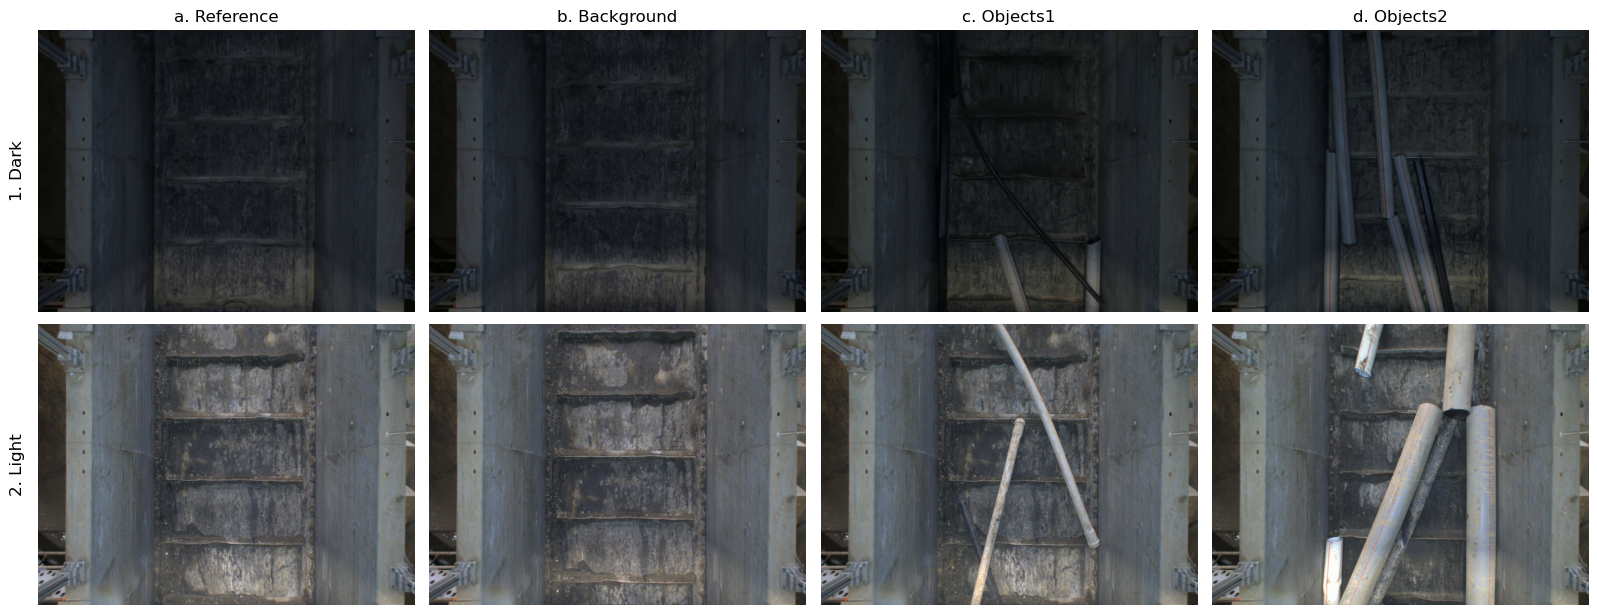

In [15]:
# display selected images

# Function to extract the type ('dark', 'light'), and category ('ref', 'bg', 'obj', 'more') from the image path
def get_image_info(image_path):
    name = image_path.split('/')[-1]
    obj_level = name.split('_')[0]
    light_level = name.split('_')[1]
    is_ref = name.split('_')[2]=='ref'
    return light_level, obj_level, is_ref

# Initialize the subplot grid
fig, axes = plt.subplots(2, 4, figsize=(.8*20,0.8*7.9))

# Loop through the image paths and plot them in the respective positions
for image_path in path_list_test:
    light_level, obj_level, is_ref = get_image_info(image_path)
    image = mpimg.imread(image_path)
    row = 0 if light_level == 'dark' else 1
    col = 0 if is_ref else (1 if obj_level == 'bg' else (2 if obj_level == 'obj' else 3))
    axes[row, col].imshow(image)
    axes[row, col].axis('off')

[axes[0, k].set_title(tit) for k,tit in enumerate(['a. Reference','b. Background','c. Objects1','d. Objects2'])]
axes[0, 0].text(-0.075, 0.5, '1. Dark', transform=axes[0, 0].transAxes, fontsize=12, rotation=90, va='center')
axes[1, 0].text(-0.075, 0.5, '2. Light', transform=axes[1, 0].transAxes, fontsize=12, rotation=90, va='center')

plt.tight_layout()
plt.savefig(path_save+'/v2i_filtering_threshold.jpg',bbox_inches='tight')
plt.show()


In [8]:
# print MSE(ref,_) and mean
light_level = ['dark','light']
object_level = ['bg','obj','more']

for ll in light_level:
    ligth_sublist = [path for path in path_list_test if ll in path]
    path_file_ref = [path for path in ligth_sublist if 'ref' in path][0]
    image1 = imreadRGB(path_file_ref)
    dyn_mean,count = updateMean(image1,0,0)
    print(f'{ll}, mean{count}: {dyn_mean}')
    for ol in object_level:
        ol_sublist = [path for path in ligth_sublist if ol in path and not 'ref' in path]
        image2 = imreadRGB(ol_sublist[0])
        #print(ol_sublist[0]) 
        dyn_mean,count = updateMean(image2,dyn_mean,count)
        print(f'{ol}, mean{count}: {dyn_mean}')
        print(f'{ll} + {ol} + mse: {mse(image1,image2):.2f}')
        print(f'{ll} + {ol} + sqrt(mse): {np.sqrt(mse(image1,image2)):.2f}')
        print('')
        

dark, mean1: 35.8772995784298
bg, mean2: 35.872429879855005
dark + bg + mse: 47.88
dark + bg + sqrt(mse): 6.92

obj, mean3: 34.77775919426928
dark + obj + mse: 98.99
dark + obj + sqrt(mse): 9.95

more, mean4: 35.74041517196684
dark + more + mse: 152.73
dark + more + sqrt(mse): 12.36

light, mean1: 92.83330854370004
bg, mean2: 92.2057510275669
light + bg + mse: 417.36
light + bg + sqrt(mse): 20.43

obj, mean3: 91.87887729389529
light + obj + mse: 354.09
light + obj + sqrt(mse): 18.82

more, mean4: 94.00438627457625
light + more + mse: 1413.53
light + more + sqrt(mse): 37.60



In [101]:
# mean of image collection

path_list_dark = collectPaths(join(path_root_images_from_videos,'CH00004','2023','03','06'))
image = imreadRGB(path_list_dark[0])
mu,cnt = updateMean(image,0,0)
for path in path_list_dark[1:]:
    image = imreadRGB(path)
    mu,cnt = updateMean(image,mu,cnt)
print(f'dark: {mu}')

path_list_light = collectPaths(join(path_root_images_from_videos,'CH00004','2023','03','17'))
image = imreadRGB(path_list_light[0])
mu,cnt = updateMean(image,0,0)
for path in path_list_light[1:]:
    image = imreadRGB(path)
    mu,cnt = updateMean(image,mu,cnt)
print(f'light: {mu}')

dark: 28.25884038520656
light: 93.06931146890392
